<h2> appendix

In [195]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances,accuracy_score
from sklearn.cluster import AgglomerativeClustering,KMeans
from scipy.spatial.distance import squareform, pdist
from scipy.stats import multivariate_normal as P
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_classification , make_circles,make_s_curve
import mpl_toolkits.mplot3d 
from scipy.spatial import distance
from scipy.spatial.distance import squareform, pdist


In [170]:
def evaluate_accuracy(predictions,labels):
    accuracy = accuracy_score(labels, predictions)
    return accuracy*100

In [189]:
def get_random_covariance(d):
    """
    Function to generate a random, valid covariance matrix of size d x d
    """
    sigma = np.random.rand(d, d) - 0.5
    sigma = np.dot(sigma, sigma.T)  # make the matrix symmetric
    return sigma


def get_random_gaussian_dist(d, distance=5):
    """
     generate a random Gaussian distribution with mean mu and covariance matrix sigma
    The distance parameter specifies the distance of the mean from the origin
    """
    sigma = get_random_covariance(d)  # generate a random covariance matrix
    mu = np.array(np.random.rand(d)) * distance  # generate a random mean
    return mu, sigma


def generate_normal_datapoint(guaussian_dist):
    """
     generate a single datapoint from a Gaussian distribution with mean and covariance matrix guaussian_dist
    """
    mean = guaussian_dist[0]
    cov = guaussian_dist[1]
    dp = np.random.multivariate_normal(mean, cov, check_valid='warn', tol=1e-8)
    return dp


def generate_gaussian_cluster(guaussian_dist, k,d = 2, dataset=None):
    """
    Function to generate a cluster of k datapoints from the Gaussian distribution guaussian_dist
    The dataset parameter can be used to append the generated cluster to an existing dataset
    gauss_dist is a tuple of the form (mean, covariance matrix)
    """
    cluster = np.empty((0, d))  # initialize an empty array to store the datapoints
    for i in range(k):
        p = generate_normal_datapoint(guaussian_dist)  # generate a single datapoint
        cluster = np.append(cluster, [p], axis=0)  # add the datapoint to the cluster
    if dataset:
        dataset = np.append(dataset, cluster)  # append the cluster to an existing dataset, if provided
    return cluster

def generate_clusters(n,k,d):
    colors =[]
    clusters = []
    # for k clusters:
    for i in range (k):
        cluster = generate_gaussian_cluster(get_random_gaussian_dist(d),n[i],d = d)
        clusters.append([cluster])
        #colors.append(np.random.uniform(0,1)/4+3*k/4)
    return clusters



<h3> MLE


In [181]:
def E_step(data, phi, mu, sigma):
    """
       Perform E-step on GMM model
       Each datapoint will find its corresponding best cluster center
       ---
       Inputs:
            data: (n, d) array, where n is # of data points and d is # of dimensions
            phi: (k, d) array, where k is # of clusters
            mu: (k, d) array, where k is # of clusters and d is # of dimensions
            sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

       Returns:
            'w': (k,n) array indicating the cluster of each data point
                        where k is # of clusters and n is # of data points
       """
    n = len(data)
    k = len(phi)
    w = np.zeros((k, n))
    log_likelyhood = 0
    
    for i in range(n):
        norm_i = 0
        for j in range(k):
            w[j, i] = P(mu[j], sigma[j]).pdf(data[i]) * phi[j]
            norm_i += w[j, i]
        w[:, i] /= norm_i
        
        log_likelyhood -= np.log(norm_i)    # compute log-likelyhood
    return w, log_likelyhood


def M_step(data, w, phi, mu, sigma):
    """
    M-step: Update our estimate of μ, σ2 and using the new values of the latent variables z.
    Inputs:
        clusters: (n) array indicating the cluster of each data point
        data: (n, d) array, where n is # of data points and d is # of dimensions
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

    Returns:
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions
    """
    sum_of_all_w = np.sum(w)
    # iterate over each gaussian, calculate μ, σ2:

    for j in range(len(mu)):
        sum_over_wj = np.sum(w[j])
        # μ <- (1/sum over wj) * weighted sum over all the data points
        mu[j] = np.sum(np.array([xi*w[j,i] for i, xi in enumerate(data)]), axis=0) / sum_over_wj
        # σ2 <- wheighted sum over all the data points in cluster((datapoint value - μ_new)**2)
        sigma[j] = np.sum(np.array([np.outer((xi - mu[j]).T, xi - mu[j]) * w[j, i] for i, xi in enumerate(data)]), axis=0)/sum_over_wj

        phi[j] = sum_over_wj/sum_of_all_w

    return phi, mu, sigma

# Input: data, model

def MLE(data, initial_model, case = 2, plot = True):
    d = data.shape[1]

    # 1. Initialize model parameters

    phi, mu, sigma = initial_model

    # 2. while not converged:
    converged = False
    i = 0
    iteration_log_likelihood = [0.0]



    while not converged and i<150:

        # 2.1     E-step: compute expected value of latent variable given current parameters
        w,lol = E_step(data , phi, mu, sigma)
        iteration_log_likelihood.append(lol)
        # 4.     M-step: update parameters to maximize expected likelihood
        if case == 1:
            PHI, SIGMA = phi, sigma
            _, mu, _ = M_step(data, w, phi, mu, sigma)
            phi, sigma = PHI, SIGMA
        if case == 2:
            phi, mu, sigma = M_step(data, w, phi, mu, sigma)
        
        # Plot:
        if plot:
            if i%20 == 0 or i < 4:
                if d == 2:
                    plt.scatter(data[:,0], data[:, 1], c=1+w[0]-w[1], alpha=0.5,cmap='RdYlBu')
                    plt.title("iteration #" + str(i))
                    plt.show()
                if d == 3:
                    fig = plt.figure()
                    ax = fig.add_subplot(111, projection='3d')
                    ax.scatter(data[:,0], data[:, 1], data[:, 2], c=1+w[0]-w[1], alpha=0.5,cmap='RdYlBu')
                    plt.title("iteration #" + str(i))
                    plt.show()
        else:
            if i%20 == 0 or i < 4:
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                c= np.argmax(w,axis=0)

                ax.scatter(data[:,0], data[:, 1], data[:, 2], c=c, alpha=0.5)
                plt.title("iteration #" + str(i))

            # for k in range(len(phi)):
                #     clust = data[np.where(w[k] == np.amax(w[k]))]
                #     ax.scatter(clust[:,0], clust[:, 1], clust[:, 2], alpha=0.5,cmap='RdYlBu')

                #print("φ: ",phi,"\n\nμ: ", mu,"\n\nσ2: ", sigma,"\n\nlog likelyhood: ", lol)
        i += 1
        converged = (abs(iteration_log_likelihood[i]-iteration_log_likelihood[i-1]) < 0.00001)
    # 5. return model
    return phi, mu, sigma,  iteration_log_likelihood


In [183]:
def initial_model(k,d,*args):
    """

    :param c: # of Gaussians in model
    :param d: # of dimentions of datapoints

    :return: an arbitrary initial condition  model for MLE. containing:
             phi: amplitude of Gaussians, np array (k)
             mu: np array(k,d)
             sigma: covariance matrix of gausians, np aray (k,d,d)


    """

    mu = np.array([np.random.multivariate_normal([0]*d, np.eye(d,d)) for i in range(k)])

    if len(args) == 0:
        phi = np.random.rand(k)
        phi /= sum(phi)


        sigmas = np.zeros((k,d,d))

        for i in range(k):
            sigma = np.random.rand(d, d)
            sigma = np.dot(sigma, sigma.T)
            sigmas[i] = sigma
        print("initiating a random model...")

    else:
        phi, sigmas = args
        print("initiating a model with given phi,sigma...")
    print("phi: ",phi,"\n\nmu: ", mu,"\n\nsigma: ", sigmas)
    return phi, mu, sigmas

In [184]:
def plot_log_likelihood(lol):
    plt.plot(range(len(lol[2:])),lol[2:])
    plt.title("log likelyhood vs. iteration no.")
    plt.xlabel("iteration")
    plt.ylabel("|log liklyhood|")
    plt.show()

In [174]:
def get_distance_2d(cluster_1, cluster_2, distance_metric="euclidean"):
    """Gets the distance between the two given 2D clusters.

    Args:
      cluster_1: A list of 2D data points.
      cluster_2: A list of 2D data points.
      distance_metric: The distance metric to use. Can be "euclidean" or "manhattan".

    Returns:
      The distance between the two clusters.
    """
    sum=0
    for data_point1 in cluster_1:
        for data_point_2 in cluster_2:

            if distance_metric == "euclidean":
                sum=sum+(data_point1-data_point_2)**2
            elif distance_metric == "manhattan":
                sum=sum+abs(data_point1-data_point_2)
    if distance_metric == "euclidean":
        sum=math.sqrt(sum)
    return sum

In [175]:
def find_closest_clusters_2d(clusters):
    """Finds the two closest clusters in the given list of 2D clusters.

    Args:
      clusters: A list of lists, where each inner list represents a 2D cluster.
      distance_metric: The distance metric to use. Can be "euclidean" or "manhattan".

    Returns:
      A list of two lists, where the first list is the first cluster and the second
      list is the second cluster.
    """

    closest_clusters = []
    closest_distance = float("inf")

    for cluster_1 in clusters:
        for cluster_2 in clusters:
            if cluster_1 [1] == cluster_2[1] and cluster_1 [0] == cluster_2[0]:
                continue

            dist = distance.euclidean(cluster_1, cluster_2)
            if dist < closest_distance:
                closest_distance = dist
                closest_clusters = [cluster_1, cluster_2]

    return closest_clusters



In [176]:
#agg optimal cluster via sklearn
def agg_optimal_clustering_case1(D,labels, K):
    # Create an instance of AgglomerativeClustering
    clustering = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')

    # Fit the model to your data
    clustering.fit(D)

    # Obtain the predicted labels
    predictions = clustering.labels_
    acuracy = evaluate_accuracy(predictions, labels)
    return predictions, acuracy
def agg_optimal_clustering_case2(D, K):
    # Create an instance of AgglomerativeClustering
    clustering = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')

    # Fit the model to your data
    clustering.fit(D)

    # Obtain the predicted labels
    predictions = clustering.labels_
    print(predictions)

    return predictions

In [177]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, labels):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    scatter=ax.scatter(x, y, s=40, c=labels, edgecolor='k')
    ax.set_aspect(1.)
    
    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    bins = np.arange(-lim, lim + binwidth, binwidth)

    unique_labels = np.unique(labels)
    array_length = len(unique_labels)
    x1 = [[] if i == 0 else [] for i in range(array_length)]
    y1 = [[] if i == 0 else [] for i in range(array_length)]
    for i in range(len(labels)):
        for l in range(len(unique_labels)):
            if unique_labels[l] == labels[i]:
                x1[l].append(x[i])
                y1[l].append(y[i])
    legend_handles = []
    for label in range(len(unique_labels)):
        legend_handles.append(scatter.legend_elements()[0][label])
    ax.legend(legend_handles, unique_labels, title='Labels')

    # Plot KDE curves
    # Plot histograms
    for i in range(len(unique_labels)):
        ax_histx.hist(x1[i], bins=bins, color=scatter.cmap(scatter.norm(unique_labels[i])),edgecolor='k')
        ax_histy.hist(y1[i], bins=bins, orientation='horizontal', color=scatter.cmap(scatter.norm(unique_labels[i])),edgecolor='k')

        # Plot KDE curves
       # sns.kdeplot(x1[i], ax=ax_histx, color=scatter.cmap(scatter.norm(unique_labels[i])))
      #  sns.kdeplot(y1[i], ax=ax_histy, color=scatter.cmap(scatter.norm(unique_labels[i])))

        # Compute mean and variance
        x_mean = np.mean(x1[i])
        x_var = np.var(x1[i])
        y_mean = np.mean(y1[i])
        y_var = np.var(y1[i])

    # Annotate mean and variance
    ax_histx.text(x_mean, -2, f"Mean: {x_mean:.2f}\nVar: {x_var:.2f}", ha='center', va='bottom', color='red',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    ax_histy.text(-1, y_mean, f"Mean: {y_mean:.2f}\nVar: {y_var:.2f}", ha='left', va='center', color='red',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

    #ax_histx.hist(x, bins=bins)
    #ax_histy.hist(y, bins=bins, orientation='horizontal')

    # Set labels for components
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Set labels for histograms
    ax_histx.set_ylabel('Probability Density')
    ax_histy.set_xlabel('Probability Density')
    

In [178]:
def scatter_plt(data, pred, accuracy,headline):
    # Start with a square Figure.
    fig = plt.figure(figsize=(6, 6))
    # Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
    # the size of the marginal axes and the main axes in both directions.
    # Also adjust the subplot parameters for a square plot.
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    # Draw the scatter plot and marginals.
    scatter_hist(data[:,0], data[:,1], ax, ax_histx, ax_histy, pred)
    if accuracy!=-1:
        ax.text(-1,-1, f"accuracy: {accuracy:.2f}", ha='left', va='center', color='red',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    fig.suptitle(headline)
    plt.show()


<h2>2D gaussian data with one center

In [190]:
k=2         # number of clusters
d=2         # number of dimentions
N = 500    # number of datapoints

phi = [0.7, 0.3]
sigma = [np.array([[0.6,0],[0,0.6]]),np.array([[0.8,-0.3],[-0.3,0.6]])]
mu = [np.array([1,1]),np.array([-1,-1])]
init = initial_model(k,d,phi,sigma)
distribution_1 = (mu[0],sigma[0])
distribution_2 = (mu[1],sigma[1])

cluster_1 = generate_gaussian_cluster(distribution_1,int(phi[0]*N),d)
cluster_2 = generate_gaussian_cluster(distribution_2,int(phi[1]*N),d)

data = np.concatenate((cluster_1,cluster_2),axis=0)

initiating a model with given phi,sigma...
phi:  [0.7, 0.3] 

mu:  [[-0.04683826  1.95111101]
 [-1.00221148  1.24556817]] 

sigma:  [array([[0.6, 0. ],
       [0. , 0.6]]), array([[ 0.8, -0.3],
       [-0.3,  0.6]])]


mle estimation using random initialization:

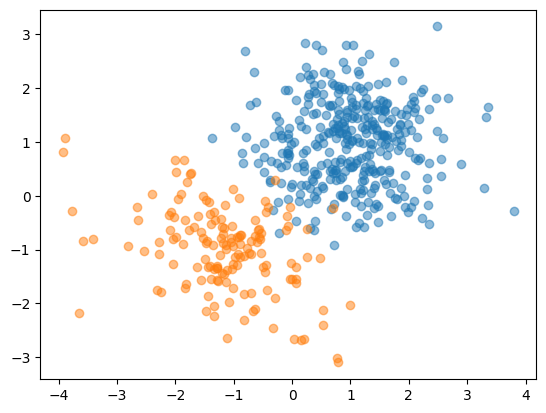

In [193]:
data = np.array(data)

#colors = np.random.rand(N)
plt.scatter(cluster_1[:,0], cluster_1[:, 1],  alpha=0.5)
plt.scatter(cluster_2[:,0], cluster_2[:, 1],  alpha=0.5)
plt.show()

initiating a model with given phi,sigma...
phi:  [0.7, 0.3] 

mu:  [[-1.21603084 -0.03539889]
 [ 0.17808482  1.27726252]] 

sigma:  [array([[0.6, 0. ],
       [0. , 0.6]]), array([[ 0.8, -0.3],
       [-0.3,  0.6]])]


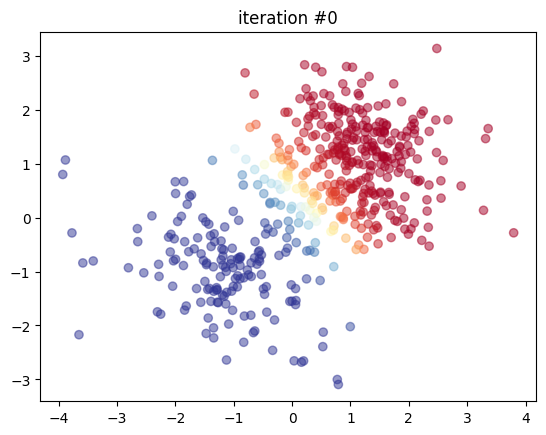

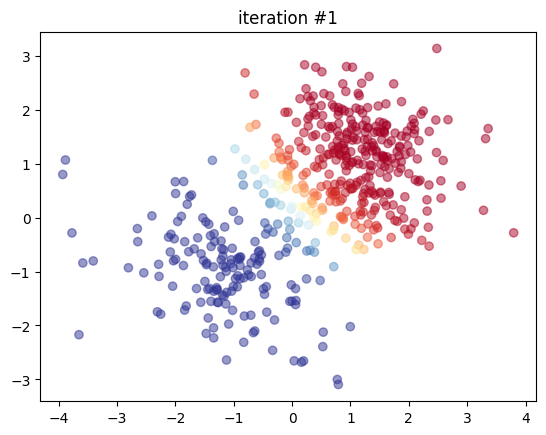

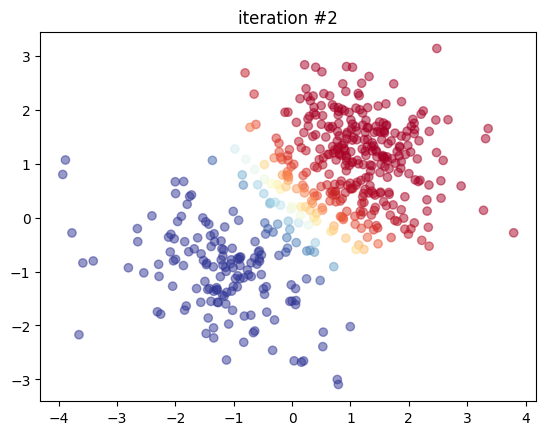

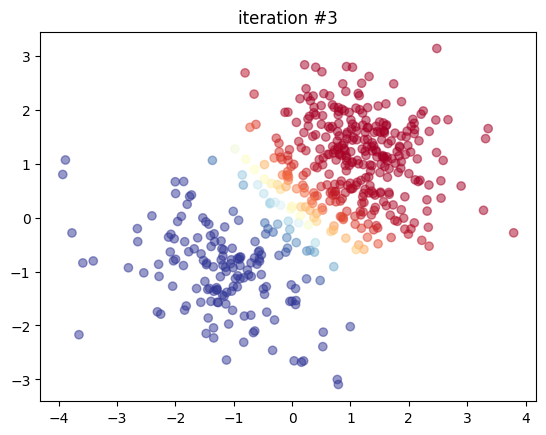

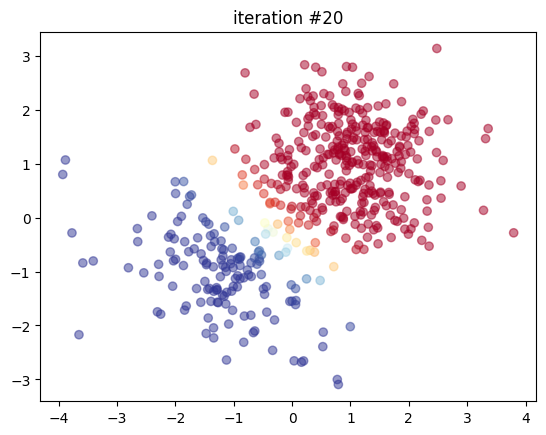

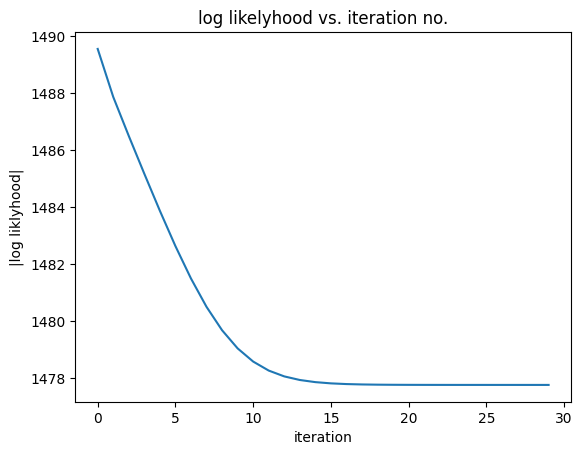

In [196]:
init = initial_model(k,d,phi,sigma)
phi, mu, sigma, lol = MLE(data,init,case=1)
plot_log_likelihood(lol)

ValueError: 'c' argument has 4 elements, which is inconsistent with 'x' and 'y' with size 1000.

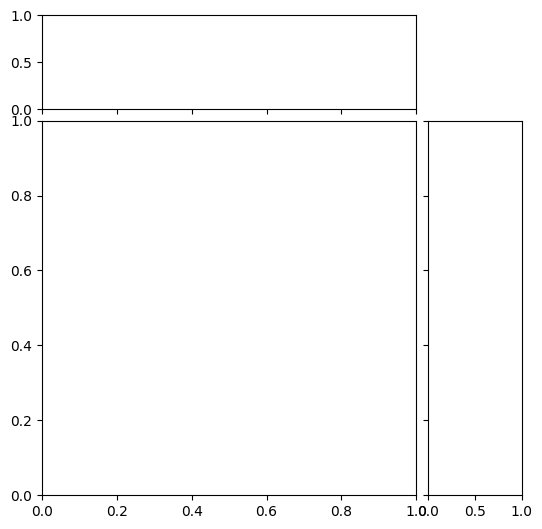

In [180]:
data, labels = make_blobs(n_samples=1000, centers=1, cluster_std=0.5, random_state=0, n_features=2)
pred1, accuracy1 = gauss_mle_cluster_case1(data, labels, sigma, p, initial_type='kmeans')

scatter_plt(data, mu, accuracy1,
                                    'MLE Estimated Gaussian Distributions with one center \n- historram and scatter plot- kmeans initialization')
    

 mle estimation using kmean initialization:

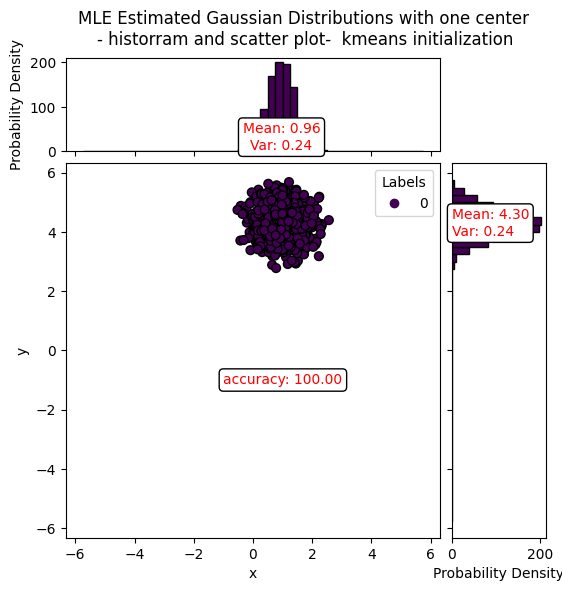

In [ ]:
pred2, accuracy2 = gauss_mle_cluster_case1(data, labels, sigma, p,k, initial_type='kmeans')
scatter_plt(data, pred2, accuracy2,
                                    'MLE Estimated Gaussian Distributions with one center \n- historram and scatter plot-  kmeans initialization')
    

agg clustering

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


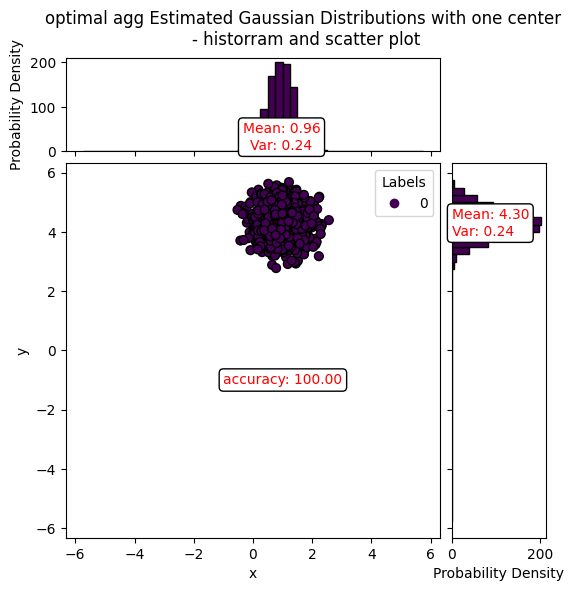

In [ ]:
pred4, accuracy4 = agg_optimal_clustering_case1(data, labels, k)
scatter_plt(data, pred4, accuracy4,
                                    'optimal agg Estimated Gaussian Distributions with one center \n- historram and scatter plot')



<h2>2D gaussian date with multiple centers

mle estimation with random initialization

In [ ]:
k=8
data, labels = make_blobs(n_samples=1000, centers=8, cluster_std=0.5, random_state=0, n_features=2)
pred1, accuracy1=gauss_mle_cluster_case1(data, labels, sigma, p,k, initial_type='rand')
scatter_plt(data, pred1, accuracy1,'MLE Estimated Gaussian Distributions with multiple centers \n- historram and scatter plot- kmeans initialization')
    

0
1
2


IndexError: list index out of range

mle estimation with kmeans initialization

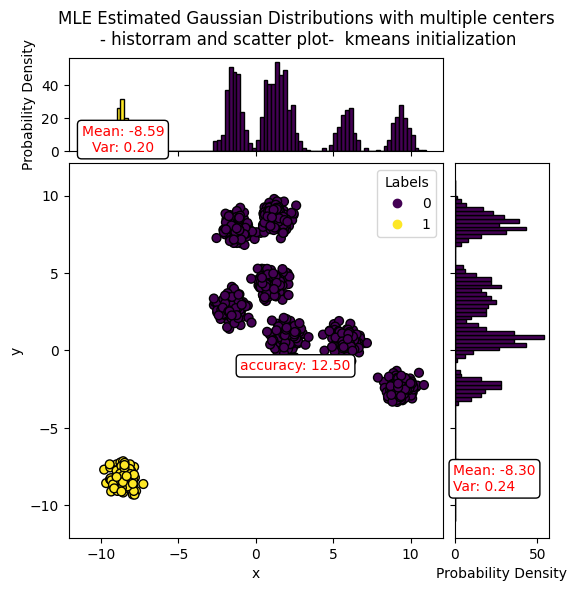

In [ ]:
pred2, accuracy2 =gauss_mle_cluster_case1(data, labels, sigma, p, initial_type='kmeans')
scatter_plt(data, pred2, accuracy2, 'MLE Estimated Gaussian Distributions with multiple centers \n- historram and scatter plot-  kmeans initialization')
    

agg clustering

In [ ]:
pred2, accuracy2 =gauss_mle_cluster_case1(data, 2)
scatter_plt(data, pred2, accuracy2, 'MLE Estimated Gaussian Distributions with multiple centers \n- historram and scatter plot-  kmeans initialization')
    

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


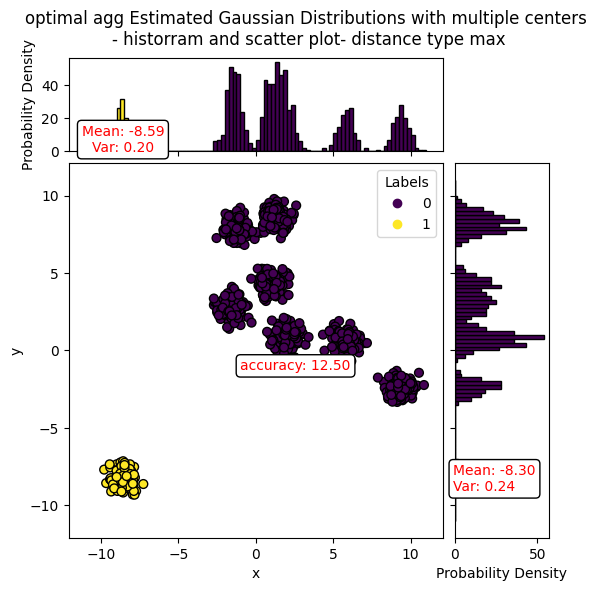

In [ ]:
pred4, accuracy4 = agg_optimal_clustering_case1(data, labels, 2)
scatter_plt(data, pred4, accuracy4,'optimal agg Estimated Gaussian Distributions with multiple centers \n- historram and scatter plot- distance type max')


<h2>2D data shaped like circles

mle estimation with random initialization

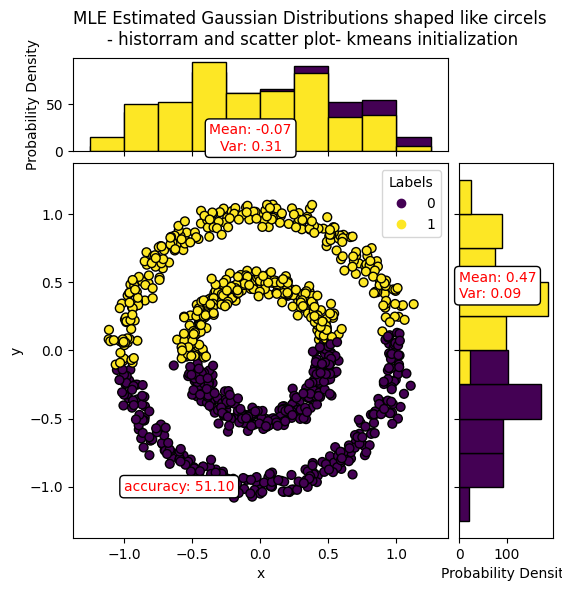

In [ ]:
data, labels = make_circles(n_samples=1000, factor=0.5, noise=0.05, random_state=0)
pred1, accuracy1 =gauss_mle_cluster_case1(data, labels, sigma, p, initial_type='rand')
scatter_plt(data, pred1, accuracy1,
                                    'MLE Estimated Gaussian Distributions shaped like circels \n- historram and scatter plot- kmeans initialization')
   

mle estimation with kmeans initialization

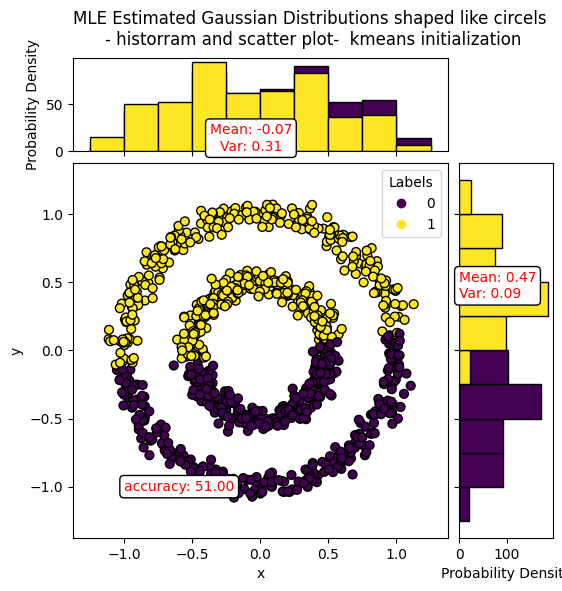

In [ ]:
pred2, accuracy2 =gauss_mle_cluster_case1(data, labels, sigma, p, initial_type='kmeans')
scatter_plt(data, pred2, accuracy2,
                                    'MLE Estimated Gaussian Distributions shaped like circels \n- historram and scatter plot-  kmeans initialization')
 

agg clustering

In [ ]:
red3, accuracy3 =agg_clustering_case1(data, labels, 2, 'min')
scatter_plt(data, pred3, accuracy3,
                                    'agg Estimated Gaussian Distributions shaped like circels \n- historram and scatter plot-  distance type min')
 

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


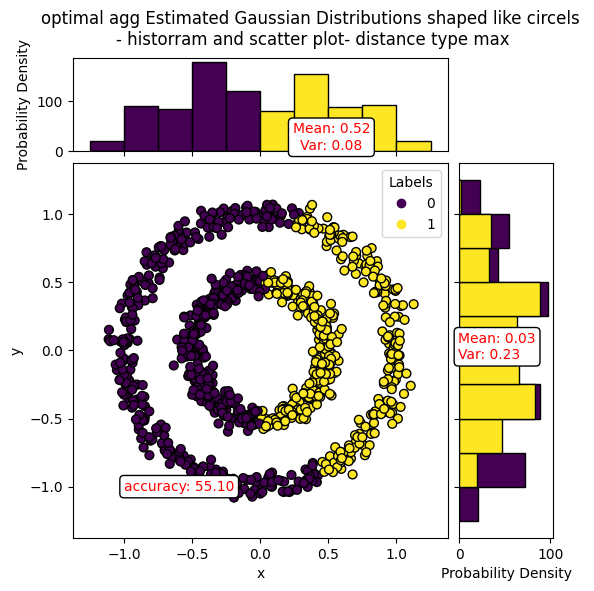

In [ ]:
pred5, accuracy5 =agg_optimal_clustering_case1(data, labels, 2)
scatter_plt(data, pred5, accuracy5,
                                    'optimal agg Estimated Gaussian Distributions shaped like circels \n- historram and scatter plot- distance type max')


<h2> 2D data shaped like moon

mle estemation with random initialization

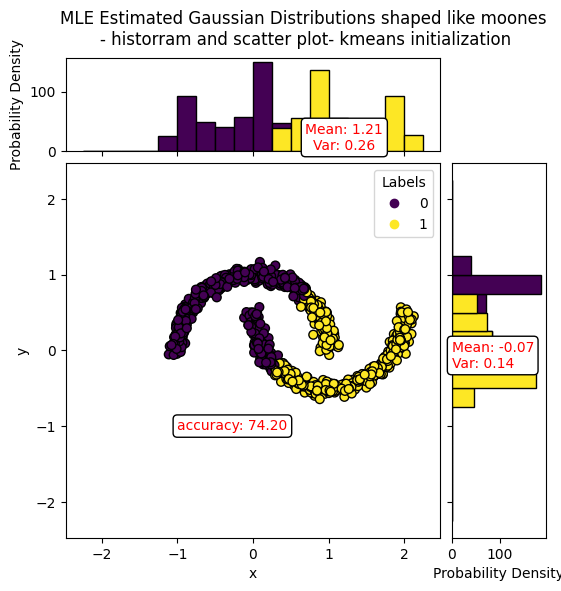

In [ ]:
data, labels = make_moons(n_samples=1000, noise=0.05)
pred1, accuracy1 =gauss_mle_cluster_case1(data, labels, sigma, p, initial_type='rand')
scatter_plt(data, pred1, accuracy1,
                                    'MLE Estimated Gaussian Distributions shaped like moones \n- historram and scatter plot- kmeans initialization')
   

mle estimation with kmeans initialization

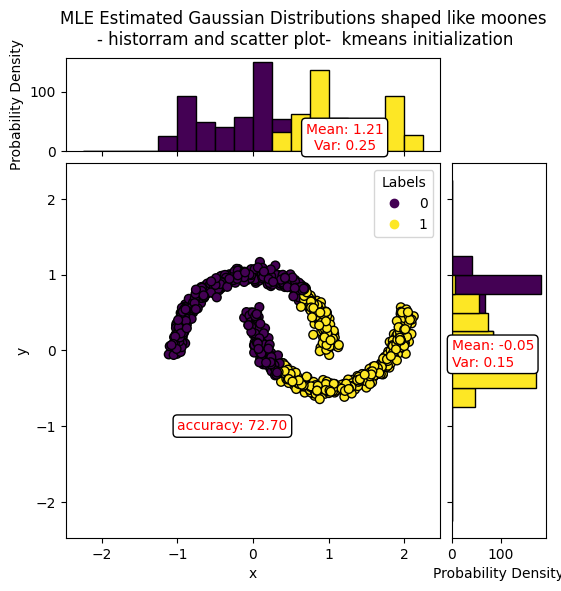

In [ ]:
pred2, accuracy2 = gauss_mle_cluster_case1(data, labels, sigma, p, initial_type='kmeans')
scatter_plt(data, pred2, accuracy2,
                                    'MLE Estimated Gaussian Distributions shaped like moones \n- historram and scatter plot-  kmeans initialization')
    

agg clastering

In [ ]:
pred3, accuracy3 =agg_clustering_case1(data, labels, 2, 'min')
scatter_plt(data, pred3, accuracy3,
                                    'agg Estimated Gaussian Distributions shaped like moones \n- historram and scatter plot-  distance type min')
    

TypeError: agg_clustering_case1() takes 3 positional arguments but 4 were given

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


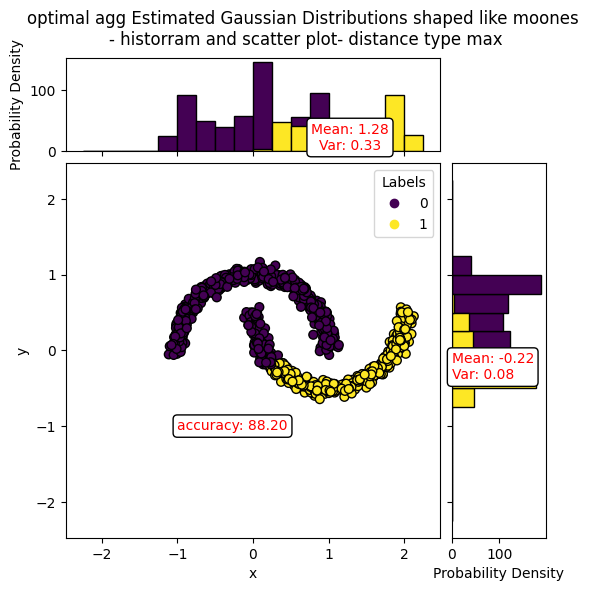

In [ ]:
pred4, accuracy4 = agg_optimal_clustering_case1(data, labels, 2)
scatter_plt(data, pred4, accuracy4,
                                    'optimal agg Estimated Gaussian Distributions shaped like moones \n- historram and scatter plot- distance type max')


<h2> uniformly spred data, shaped like a squre

mle estimation with random initialization

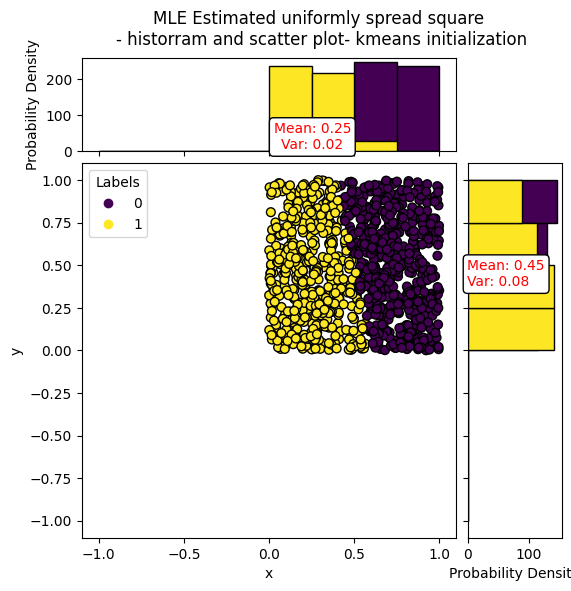

In [ ]:
square = np.random.rand(1000, 2)
pred1 =gauss_mle_cluster_case2(square, sigma, p, initial_type='rand')
scatter_plt(square, pred1, -1,
                                    'MLE Estimated uniformly spread square \n- historram and scatter plot- kmeans initialization')
    

mle estimation with kmeans initialization

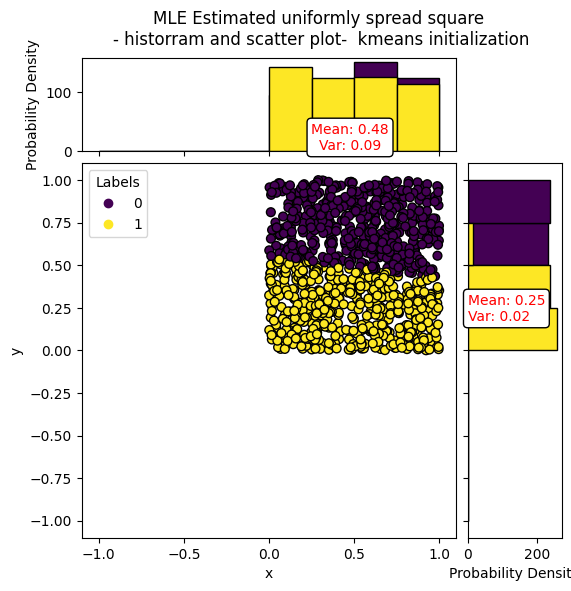

In [ ]:
pred2 = gauss_mle_cluster_case2(square, sigma, p, initial_type='kmeans')
scatter_plt(square, pred2, -1,
                                    'MLE Estimated uniformly spread square \n- historram and scatter plot-  kmeans initialization')
    

agg clustering

In [ ]:
pred3 =agg_clustering_case2(square, 2, 'min')
scatter_plt(square, pred3,-1,
                                    'agg Estimated uniformly spread square \n- historram and scatter plot-  distance type min')
    

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


[1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0
 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 1
 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1
 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1
 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1
 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0
 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1
 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1
 1 0 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0
 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0
 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1
 1 0 0 1 0 0 0 1 1 1 0 0 

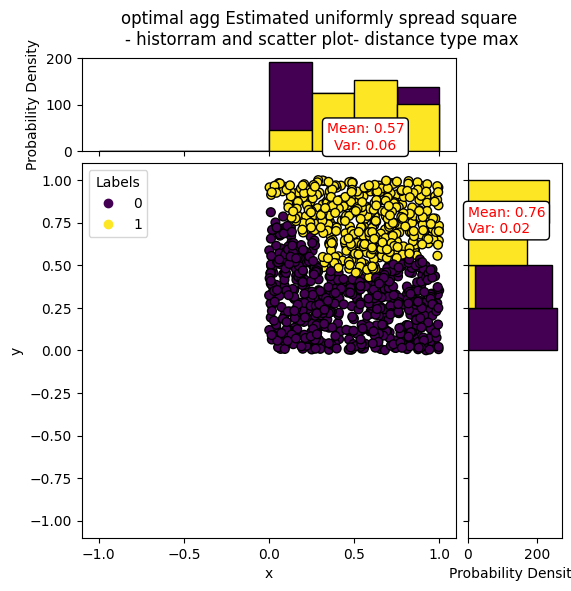

In [ ]:
pred5 =agg_optimal_clustering_case2(square, 2)
scatter_plt(square, pred5, -1,
                                    'optimal agg Estimated uniformly spread square \n- historram and scatter plot- distance type max')



<h2> uniformly spred data, shaped like parallelogram

mle estimation with random initialization

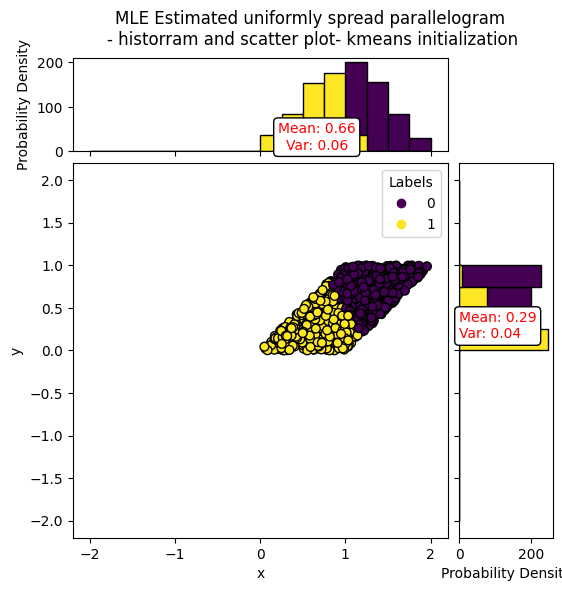

In [ ]:
parallelogram = np.random.rand(1000, 2)
parallelogram[:, 0] = parallelogram[:, 0] + parallelogram[:, 1]
pred1 =gauss_mle_cluster_case2( parallelogram, sigma, p, initial_type='rand')
scatter_plt( parallelogram, pred1, -1,
                                    'MLE Estimated uniformly spread parallelogram \n- historram and scatter plot- kmeans initialization')
    

mle estimation with kmeans initialization

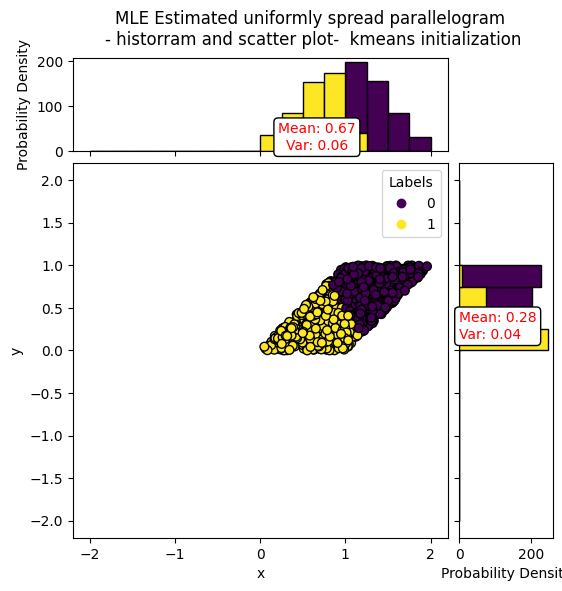

In [ ]:
pred2 =gauss_mle_cluster_case2( parallelogram, sigma, p, initial_type='kmeans')
scatter_plt( parallelogram, pred2, -1,
                                    'MLE Estimated uniformly spread parallelogram \n- historram and scatter plot-  kmeans initialization')
    

agg clustering

In [ ]:
pred3 =agg_clustering_case2( parallelogram, 2, 'min')
scatter_plt( parallelogram, pred3, -1,
                                    'agg Estimated uniformly spread parallelogram \n- historram and scatter plot-  distance type min')
    

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


[1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1
 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1
 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1
 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1
 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0
 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0
 1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1
 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1
 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0
 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0
 0 1 0 0 1 0 0 1 0 0 0 0 

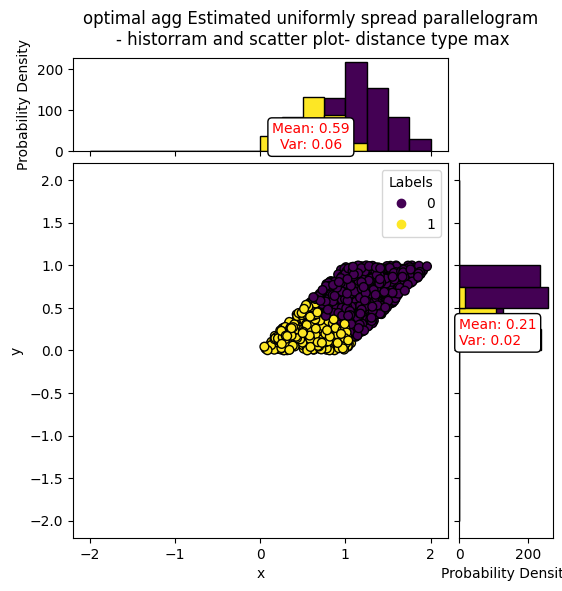

In [ ]:
pred4 =agg_optimal_clustering_case2( parallelogram, 2)
scatter_plt( parallelogram, pred4, -1,
                                    'optimal agg Estimated uniformly spread parallelogram \n- historram and scatter plot- distance type max')


<h2> uniformly spred data, shaped like triangle

mle estimation with random initialization

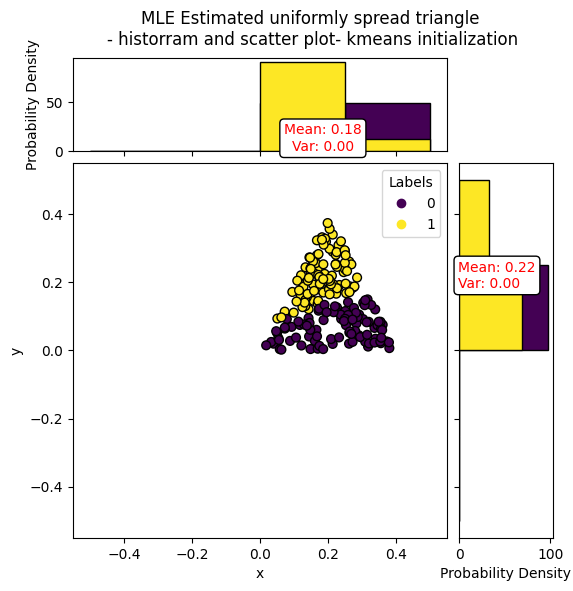

In [ ]:
v1 = np.array([0, 0])
v2 = np.array([0.2, 0.4])
v3 = np.array([0.4, 0])
u = np.random.uniform(size=(200, 1))
v = np.random.uniform(size=(200, 1))
triangle = (1 - np.sqrt(u)) * v1 + (np.sqrt(u) * (1 - v)) * v2 + (np.sqrt(u) * v) * v3
pred1 = gauss_mle_cluster_case2(triangle, sigma, p, initial_type='rand')
scatter_plt(triangle, pred1, -1,
                                    'MLE Estimated uniformly spread triangle \n- historram and scatter plot- kmeans initialization')
    

mle estimation with kmeans initialization

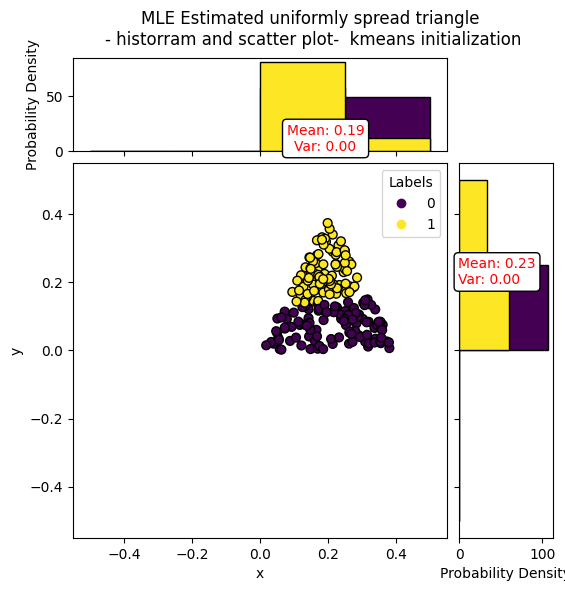

In [ ]:
pred2 =gauss_mle_cluster_case2(triangle, sigma, p, initial_type='kmeans')
scatter_plt(triangle, pred2, -1,
                                    'MLE Estimated uniformly spread triangle \n- historram and scatter plot-  kmeans initialization')
    

agg clustering

In [ ]:
pred3 =agg_clustering_case2(triangle, 2, 'min')
scatter_plt(triangle, pred3, -1,
                                    'agg Estimated uniformly spread triangle \n- historram and scatter plot-  distance type min')
   

TypeError: agg_clustering_case2() takes 1 positional argument but 3 were given

c:\Users\User\PycharmProjects\pythonProject1\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


[1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1
 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1
 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0
 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1
 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0]


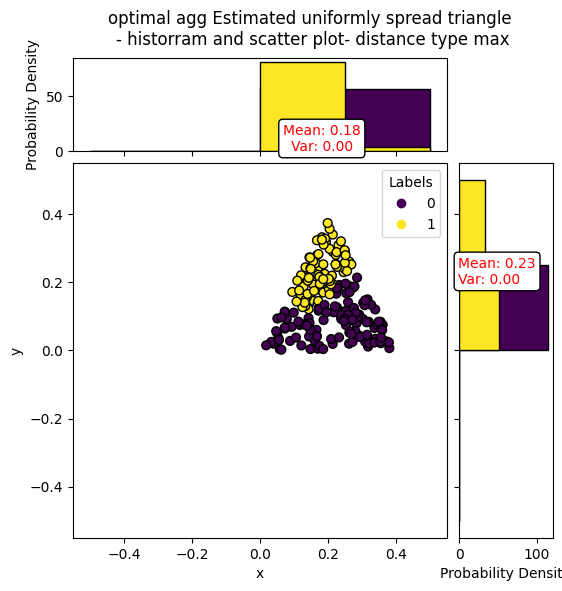

In [ ]:
pred4 = agg_optimal_clustering_case2(triangle, 2)
scatter_plt(triangle, pred4, -1,
                                    'optimal agg Estimated uniformly spread triangle \n- historram and scatter plot- distance type max')
